In [4]:
isColab=True
if isColab:
    !pip install infomap

  Could not fetch URL https://pypi.python.org/simple/infomap/: There was a problem confirming the ssl certificate: [SSL: TLSV1_ALERT_PROTOCOL_VERSION] tlsv1 alert protocol version (_ssl.c:661) - skipping
  Could not find a version that satisfies the requirement infomap (from versions: )
No matching distribution found for infomap


In [3]:
# To install or upgrade to to the latest version of Infomap, see https://mapequation.github.io/infomap/
import infomap
import networkx as nx
import pydot
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
%matplotlib inline
import seaborn as sns
from  matplotlib.ticker import FuncFormatter
sns.set(style="white")

ModuleNotFoundError: No module named 'infomap'

# Run data prepocessing notebook first
you will generate a preprocesses version of our Influence Matrix

# Load the input data

In [ ]:
if(isColab):
    data_folder='https://raw.githubusercontent.com/marota/powergrid_segmentation/master/data'#data depuis github
else:
    data_folder = os.path.join(os.getcwd(), "data") #data en local

In [6]:
import zipfile
import requests
import os
import io

x_input_zip=os.path.join(data_folder,'InfluenceMatrix.zip')
if(isColab):
    ####data sur github
    r = requests.get(x_input_zip)
    zipfile_xinput = zipfile.ZipFile(io.BytesIO(r.content))
else:
    ######data en local
    zipfile_xinput = zipfile.ZipFile(x_input_zip)


In [7]:
#mettre un warning
input_data_init = pd.read_csv(zipfile_xinput.open('InfluenceMatrix/AS_table_preprocessed_withTopo.csv'), index_col=0)#pd.read_csv('InfluenceMatrix/AS_table.csv', index_col=0)

#reduce memory footprint
input_data=input_data_init.astype('float16')
del input_data_init


In [8]:
input_data.head()

,line_15,line_16,line_189,line_190,line_297,line_298,line_299,line_300,line_301,line_302,...,line_8099,line_8100,line_8101,line_8102,line_8103,line_8104,line_8105,line_8106,line_8107,line_8108
line_15,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
line_16,98.8125,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
line_189,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
line_190,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
line_297,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Create an Influence graph

In [6]:
G = nx.DiGraph(input_data.values)

#G.add_nodes(G.nodes)
quadNames=list(input_data)
for node in G.nodes():
    G.add_node(node, name=quadNames[node])


In [7]:
#keep only biggest connected components
print("number of nodes before:"+str(G.number_of_nodes()))
largest_cc = max(nx.weakly_connected_components(G), key=len)
G=G.subgraph(largest_cc)
print("number of nodes after:"+str(G.number_of_nodes()))

number of nodes before:7769
number of nodes after:7769


# Use Infomap to partition

## Find communities in the influence graph

In [8]:
def findCommunities(G,seed=1):
    """
    Partition network with the Infomap algorithm.
    Annotates nodes with 'community' id.
    """

    myInfomap = infomap.Infomap("-d --seed " + str(seed))
    communities = {}
    print("Building Infomap network from a NetworkX graph...")
    myInfomap.add_links(G.edges)

    print("Find communities with Infomap...")
    myInfomap.run()

    print(f"Found {myInfomap.num_top_modules} top modules with codelength: {myInfomap.codelength}")
    for node in myInfomap.nodes:
        path = node.path    
        communities[node.node_id] = str(":".join([str(i) for i in path[:-1]]))
    # print(type(communities))
    # print(communities[:3])
    # communities = myInfomap.getModules()
    # print(type(communities))
    # print(communities[3:])
    #communities = [node.path for node in myInfomap.iterLeafNodes()]# myInfomap.getModules() iterLeafNodes()
    nx.set_node_attributes(G, communities, 'community')
    return myInfomap.codelength

In [9]:
def printCommunities(G,seed=1,outfile="outfile.tree"):
    """
    Partition network with the Infomap algorithm.
    Annotates nodes with 'community' id.
    """

    myInfomap = infomap.Infomap("-d --seed " + str(seed))
    communities = {}
    print("Building Infomap network from a NetworkX graph...")
    myInfomap.add_links(G.edges)

    print("Find communities with Infomap...")
    myInfomap.run()

    print(f"Found {myInfomap.num_top_modules} top modules with codelength: {myInfomap.codelength}")
    print(f"Writing results to {outfile}")
    myInfomap.write_tree(outfile)
    return myInfomap.codelength

In [10]:
findCommunities(G)

Building Infomap network from a NetworkX graph...
Find communities with Infomap...
Found 5 top modules with codelength: 10.081569168844036


10.081569168844036

## Study Communities

In [11]:
communities = [v for k,v in nx.get_node_attributes(G, 'community').items()]
itemNames = [v for k,v in nx.get_node_attributes(G, 'name').items()]

In [12]:
communities[:10]

['1:4', '1:4', '1:9', '1:9', '1:9', '1:9', '1:5', '1:9', '1:9', '1:9']

### Create a proper dataframe

In [13]:
def levelsInDataframe(InfluenceGraph):
    #intialize data
    communities = [v for k,v in nx.get_node_attributes(G, 'community').items()]
    itemNames = [v for k,v in nx.get_node_attributes(G, 'name').items()]
    
    modules=[s.split(":") for s in communities]
    maxDepth=max(len(x) for x in modules )
    print("the maximum depth is:"+str(maxDepth))
    ids=[i for i in range(len(communities))]
    
    #intialize dataframe
    numRows=len(ids)
    numCols=1+maxDepth
    df = pd.DataFrame(-1,index=range(numRows),columns=range(numCols))
    colNames=['ids']+["M"+str(i) for i in range(maxDepth)]
    df.columns = colNames
    print(df.columns)
    
    #set values in dataframe
    df['ids']=ids
    df.index=itemNames
    #df.index.names =itemNames
    for (i,mod) in zip(ids,modules):
        nModules=len(mod)
        colRange=[m for m in range(1,nModules+1)]
        df.iloc[i,colRange]=np.array(mod, dtype=np.integer)
    
        
    
    return df
    

In [14]:

levelsDF=levelsInDataframe(G)

the maximum depth is:3
Index(['ids', 'M0', 'M1', 'M2'], dtype='object')


In [15]:
levelsDF

,ids,M0,M1,M2
line_15,0,1,4,-1
line_16,1,1,4,-1
line_189,2,1,9,-1
line_190,3,1,9,-1
line_297,4,1,9,-1
...,...,...,...,...
line_8104,7764,1,12,-1
line_8105,7765,1,7,-1
line_8106,7766,1,7,-1
line_8107,7767,1,12,-1


In [16]:
unique, counts = np.unique(levelsDF['M0'], return_counts=True)

In [17]:
unique

array([1, 2, 3, 4, 5])

In [18]:
counts

array([7752,    3,    2,    7,    5])

In [19]:
SelectedLevel='M0'
levelsDF[SelectedLevel].values

array([1, 1, 1, ..., 1, 1, 1])

## Visualize communities
We should get coordinates for the node of our graph. However it should be coordinates of the power grid graph and not infered directly from the influence graph. For the time being however, let's generate coordinates from the influence graph.

In [20]:

#pos = nx.nx_pydot.graphviz_layout(G, prog='dot')

In [21]:
import datetime

generatePos=False
if generatePos:
    start = datetime.datetime.now()
    pos = nx.spring_layout(G)
    finish = datetime.datetime.now()
    executionTime=finish-start
    executionTime
    pos

In [22]:
posDF = pd.read_csv(os.path.join(data_folder,'PostesCoords.csv'), index_col=0)
posDF

,nameQuad,voltage,subOr,subEx,xOr,yOr,xEx,yEx
0,line_0,63.0,sub_4870,sub_1936,-0.253945,43.707063,-0.560849,43.655506
1,line_1,63.0,sub_4870,sub_130,-0.253945,43.707063,-0.298266,43.593053
2,line_2,63.0,sub_4870,sub_2961,-0.253945,43.707063,-0.383617,43.789211
3,line_3,225.0,sub_1985,sub_2536,5.923198,45.696338,5.911382,45.592227
4,line_4,63.0,sub_1985,sub_4492,5.923198,45.696338,5.923631,45.650041
...,...,...,...,...,...,...,...,...
8104,line_8104,63.0,sub_2659,sub_605,-0.752166,45.230985,-0.745990,45.207574
8105,line_8105,63.0,sub_4686,sub_3035,6.974656,43.555249,6.789638,43.470678
8106,line_8106,225.0,sub_1303,sub_1225,6.067386,43.751832,6.139068,43.756096
8107,line_8107,90.0,sub_3389,sub_1254,0.343033,46.623447,0.310492,46.609016


In [23]:
len(posDF)

8109

In [24]:
#filter quads in Service
indices=[i for i in range(0,len(posDF)) if posDF['nameQuad'].iloc[i] in itemNames]

In [25]:
AdjacencyMatrix=posDF.iloc[indices][['subOr','subEx','nameQuad']]
#AdjacencyMatrix.columns = ['nomPosteOr','nomPosteEx','quadName']

In [26]:
AdjacencyMatrix=AdjacencyMatrix.reset_index(drop = True) 
AdjacencyMatrix

,subOr,subEx,nameQuad
0,sub_4870,sub_1936,line_0
1,sub_4870,sub_130,line_1
2,sub_4870,sub_2961,line_2
3,sub_1148,sub_1394,line_5
4,sub_149,sub_2397,line_6
...,...,...,...
7818,sub_2659,sub_605,line_8104
7819,sub_4686,sub_3035,line_8105
7820,sub_1303,sub_1225,line_8106
7821,sub_3389,sub_1254,line_8107


In [27]:
latOr = posDF['yOr']
lonOr = posDF['xOr']
names=posDF['subOr']
# define position in basemap
position = {}
for i in range(0, len(lonOr)):
    position[names[i]] = [lonOr[i], latOr[i]]

In [28]:
latEx = posDF['yEx']
lonEx = posDF['xEx']
names=posDF['subEx']
# define position in basemap

for i in range(0, len(lonEx)):
    position[names[i]] = [lonEx[i], latEx[i]]

In [29]:
Grid = nx.from_pandas_edgelist(AdjacencyMatrix, 'subOr', 'subEx', ['nameQuad'])

In [30]:
nx.set_node_attributes(Grid, position, 'pos')

### Create plotly graph

A method to create plotly edges given edge coordinates, a color and the name of the community they belong to

In [31]:

def createEdges(edges_x,edges_y,colorEdges,communityName):
    trace = go.Scatter(
                x=edges_x,#tuple([x0, x1, None]),
                y=edges_y,#tuple([y0, y1, None]),
                line=dict(width=3),
                marker=dict(color=colorEdges),
                #hovertext=communityName,
                name=communityName,
                mode='lines')
    return trace

A method to create plotly nodes given node coordinates

In [32]:
def creatNodes(nodes_x,nodes_y):
    node_trace = go.Scatter(
        x=nodes_x, y=nodes_y,
        mode='markers',
        hoverinfo='text',
        marker=dict(
            showscale=False,
            colorscale='YlGnBu',
            reversescale=True,
            color=[],
            size=1,
            line_width=2))
    
    return node_trace

A method to create a plotly network give a networkx graph and a table with the communities of each edges

In [33]:
from collections import defaultdict

def createPlotlyNetwork(G,communitiesInLevel=None):

    
    colorArray=list(mcd.CSS4_COLORS)
    ncolors=len(colorArray)
    colors=[]
    traceRecode=[]
    
    community_traces_x=defaultdict(list)
    community_traces_y=defaultdict(list)
    
    #extract edge coordinates and community from networkx graph
    for source,target,data in G.edges(data=True):
        edge_x = []
        edge_y = []
        x0, y0 = G.nodes[source]['pos']
        x1, y1 = G.nodes[target]['pos']
        edge_x.append(x0)
        edge_x.append(x1)
        edge_x.append(None)
        edge_y.append(y0)
        edge_y.append(y1)
        edge_y.append(None)
        
        quadName=data['nameQuad']
        community=communitiesInLevel[quadName]
        
        if community not in community_traces_x.keys():
            community_traces_x[community]=edge_x
            community_traces_y[community]=edge_y
        else:
            community_traces_x[community]+=edge_x
            community_traces_y[community]+=edge_y
            

    #create edges for each community
    for community in community_traces_x.keys():
        edges_x=community_traces_x[community]
        edges_y=community_traces_y[community]
        colorCommunity=colorArray[community % ncolors]
        trace = createEdges(edges_x,edges_y,colorCommunity,str(community))

        traceRecode.append(trace)      
        

    #create nodes for each community
    nodes_x = []
    nodes_y = []
    
    for node in G.nodes():
        x, y = G.nodes[node]['pos']
        nodes_x.append(x)
        nodes_y.append(y)

    node_trace=creatNodes(nodes_x,nodes_y)
    traceRecode.append(node_trace)
    
    return traceRecode#edge_trace, node_trace

A method to draw a plotly network

In [34]:
def drawPlotlyNewtork(G,communitiesInLevel=None):
    #edge_trace, node_trace=createEdgesPlotly(G,communitiesInLevel)
    traceRecode=createPlotlyNetwork(G,communitiesInLevel)
    
    fig =  go.Figure()
    for trace in traceRecode:
        fig.add_trace(trace)
    
    fig.show()

### Draw plotly graph

In [38]:
SelectedLevel='M0'
communitiesInLevel=levelsDF[SelectedLevel]

In [39]:
import plotly.graph_objects as go
import matplotlib._color_data as mcd
colorArray=list(mcd.CSS4_COLORS)
ncolors=len(colorArray)


colors=[colorArray[communitiesInLevel[i]%ncolors] for i in range(0,len(communitiesInLevel))]

In [40]:
doDraw=True

if doDraw:
    drawPlotlyNewtork(Grid,communitiesInLevel)


# Analyze communities robustness

In [39]:
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)

#### Update to latest partition validation code

In [40]:
%%bash
#Clone partition-validation repo if it does not exist, otherwhise pull. Then compile.
if [ ! -d "partition-validation" ] ; then
    git clone https://github.com/mapequation/partition-validation.git
else
    git -C partition-validation pull
fi
make -C partition-validation

Already up to date.
make: `partition-validation' is up to date.


#### Find new solutions until complete solution landscape
Run many partitioning iterations to find the good enough number of iterations to reach given solution landscape accuracy

In [ ]:
os.makedirs('results',exist_ok=True)

In [41]:
distance_threshold = 0.2
accuracy = 0.9
currentValidationScore = 0.0
n_validation = 10
n_samples = 100
validation_data = pd.DataFrame(columns = ["n_validated","n_clusters","n_partitions","n_training","n_validation"])
partitions = pd.DataFrame()
niter = 1000
for i in range(niter):
    print("Iteration " + str(i+1))
    codelength = findCommunities(G,i)
    communities = [v for k,v in nx.get_node_attributes(G, 'community').items()]
    communities.insert(0,codelength)
    partitions = pd.concat([partitions, pd.DataFrame(communities,columns = [str(i)])], axis=1)
    
    if (i+1) % (2*n_validation) == 0:
        n_training = i+1-n_validation
        print("Running partition validation with " + str(n_training) + " training partitions and " + str(n_validation) + " validation partitions.")
        partitions.sort_values(by=0, axis=1,inplace=True)
        partitions.drop(0, axis=0,inplace=False).to_csv(r'results/partitions.csv',index=False,header=False,sep=' ')    
        !partition-validation/partition-validation -s 123 -t $distance_threshold --validation-sampling $n_training $n_validation $n_samples results/partitions.csv results/partitions_clustering.txt
        validation_data_tmp = pd.read_csv('results/partitions_clustering_validation.txt',skiprows=1,header=None,delimiter=' ').rename(columns={0: "n_validated", 1: "n_clusters"})
        validation_data_tmp["n_partitions"] = i+1
        validation_data_tmp["n_training"] = n_training
        validation_data_tmp["n_validation"] = n_validation
        currentValidationScore = validation_data_tmp['n_validated'].median()/n_validation
        print(str(100*currentValidationScore) + "% of validation partitions fit in partition clusters from " + str(n_training) + " training clusters.")
        validation_data = validation_data.append(validation_data_tmp,sort=False)
    
    if currentValidationScore > accuracy:
        break

Iteration 1
Building Infomap network from a NetworkX graph...
Find communities with Infomap...
Found 209 top modules with codelength: 10.061153426408307
Iteration 2
Building Infomap network from a NetworkX graph...
Find communities with Infomap...
Found 5 top modules with codelength: 10.081569168844036
Iteration 3
Building Infomap network from a NetworkX graph...
Find communities with Infomap...
Found 206 top modules with codelength: 10.088175723125449
Iteration 4
Building Infomap network from a NetworkX graph...
Find communities with Infomap...
Found 204 top modules with codelength: 10.037708236956421
Iteration 5
Building Infomap network from a NetworkX graph...
Find communities with Infomap...
Found 6 top modules with codelength: 10.021130443369788
Iteration 6
Building Infomap network from a NetworkX graph...
Find communities with Infomap...
Found 215 top modules with codelength: 10.055120644290525
Iteration 7
Building Infomap network from a NetworkX graph...
Find communities with In

80.0% of validation partitions fit in partition clusters from 10 training clusters.
Iteration 21
Building Infomap network from a NetworkX graph...
Find communities with Infomap...
Found 205 top modules with codelength: 10.040865747042147
Iteration 22
Building Infomap network from a NetworkX graph...
Find communities with Infomap...
Found 6 top modules with codelength: 10.060617129769176
Iteration 23
Building Infomap network from a NetworkX graph...
Find communities with Infomap...
Found 204 top modules with codelength: 10.043992269639753
Iteration 24
Building Infomap network from a NetworkX graph...
Find communities with Infomap...
Found 201 top modules with codelength: 10.063199323747192
Iteration 25
Building Infomap network from a NetworkX graph...
Find communities with Infomap...
Found 3 top modules with codelength: 10.068761002656982
Iteration 26
Building Infomap network from a NetworkX graph...
Find communities with Infomap...
Found 218 top modules with codelength: 10.045380090060

-->Number of validation partitions out of 10 that fits in one of 8 clusters is...8. 
-->Fraction of validation partitions that fits in a cluster after 43 samples: 0.797674
Clustering 30 partitions:
-->Number of validation partitions out of 10 that fits in one of 11 clusters is...10. 
-->Fraction of validation partitions that fits in a cluster after 44 samples: 0.802273
Clustering 30 partitions:
-->Number of validation partitions out of 10 that fits in one of 9 clusters is...9. 
-->Fraction of validation partitions that fits in a cluster after 45 samples: 0.804444
Clustering 30 partitions:
-->Number of validation partitions out of 10 that fits in one of 10 clusters is...10. 
-->Fraction of validation partitions that fits in a cluster after 46 samples: 0.808696
Clustering 30 partitions:
-->Number of validation partitions out of 10 that fits in one of 10 clusters is...10. 
-->Fraction of validation partitions that fits in a cluster after 47 samples: 0.812766
Clustering 30 partitions:
-->N

80.0% of validation partitions fit in partition clusters from 30 training clusters.
Iteration 41
Building Infomap network from a NetworkX graph...
Find communities with Infomap...
Found 4 top modules with codelength: 10.065321239846094
Iteration 42
Building Infomap network from a NetworkX graph...
Find communities with Infomap...
Found 216 top modules with codelength: 10.064496459878612
Iteration 43
Building Infomap network from a NetworkX graph...
Find communities with Infomap...
Found 5 top modules with codelength: 10.052898883254283
Iteration 44
Building Infomap network from a NetworkX graph...
Find communities with Infomap...
Found 3 top modules with codelength: 10.055149506127544
Iteration 45
Building Infomap network from a NetworkX graph...
Find communities with Infomap...
Found 3 top modules with codelength: 10.067564202284656
Iteration 46
Building Infomap network from a NetworkX graph...
Find communities with Infomap...
Found 3 top modules with codelength: 10.063037694773962
It

-->Number of validation partitions out of 10 that fits in one of 9 clusters is...7. 
-->Fraction of validation partitions that fits in a cluster after 36 samples: 0.875
Clustering 50 partitions:
-->Number of validation partitions out of 10 that fits in one of 12 clusters is...10. 
-->Fraction of validation partitions that fits in a cluster after 37 samples: 0.878378
Clustering 50 partitions:
-->Number of validation partitions out of 10 that fits in one of 9 clusters is...7. 
-->Fraction of validation partitions that fits in a cluster after 38 samples: 0.873684
Clustering 50 partitions:
-->Number of validation partitions out of 10 that fits in one of 11 clusters is...9. 
-->Fraction of validation partitions that fits in a cluster after 39 samples: 0.874359
Clustering 50 partitions:
-->Number of validation partitions out of 10 that fits in one of 10 clusters is...10. 
-->Fraction of validation partitions that fits in a cluster after 40 samples: 0.8775
Clustering 50 partitions:
-->Number 

-->Number of validation partitions out of 10 that fits in one of 12 clusters is...9. 
-->Fraction of validation partitions that fits in a cluster after 99 samples: 0.865657
Clustering 50 partitions:
-->Number of validation partitions out of 10 that fits in one of 8 clusters is...6. 
-->Fraction of validation partitions that fits in a cluster after 100 samples: 0.863
90.0% of validation partitions fit in partition clusters from 50 training clusters.
Iteration 61
Building Infomap network from a NetworkX graph...
Find communities with Infomap...
Found 207 top modules with codelength: 10.079222528304907
Iteration 62
Building Infomap network from a NetworkX graph...
Find communities with Infomap...
Found 208 top modules with codelength: 10.095669915479247
Iteration 63
Building Infomap network from a NetworkX graph...
Find communities with Infomap...
Found 6 top modules with codelength: 10.085272456225626
Iteration 64
Building Infomap network from a NetworkX graph...
Find communities with In

90.0% of validation partitions fit in partition clusters from 70 training clusters.
Iteration 81
Building Infomap network from a NetworkX graph...
Find communities with Infomap...
Found 207 top modules with codelength: 10.037731905033528
Iteration 82
Building Infomap network from a NetworkX graph...
Find communities with Infomap...
Found 3 top modules with codelength: 10.083575855090755
Iteration 83
Building Infomap network from a NetworkX graph...
Find communities with Infomap...
Found 198 top modules with codelength: 10.070827985501776
Iteration 84
Building Infomap network from a NetworkX graph...
Find communities with Infomap...
Found 209 top modules with codelength: 10.060250031268078
Iteration 85
Building Infomap network from a NetworkX graph...
Find communities with Infomap...
Found 201 top modules with codelength: 10.069577060600128
Iteration 86
Building Infomap network from a NetworkX graph...
Find communities with Infomap...
Found 201 top modules with codelength: 10.0430401236

-->Number of validation partitions out of 10 that fits in one of 13 clusters is...8. 
-->Fraction of validation partitions that fits in a cluster after 64 samples: 0.926562
Clustering 90 partitions:
-->Number of validation partitions out of 10 that fits in one of 12 clusters is...10. 
-->Fraction of validation partitions that fits in a cluster after 65 samples: 0.927692
Clustering 90 partitions:
-->Number of validation partitions out of 10 that fits in one of 11 clusters is...9. 
-->Fraction of validation partitions that fits in a cluster after 66 samples: 0.927273
Clustering 90 partitions:
-->Number of validation partitions out of 10 that fits in one of 11 clusters is...9. 
-->Fraction of validation partitions that fits in a cluster after 67 samples: 0.926866
Clustering 90 partitions:
-->Number of validation partitions out of 10 that fits in one of 15 clusters is...9. 
-->Fraction of validation partitions that fits in a cluster after 68 samples: 0.926471
Clustering 90 partitions:
-->N

/opt/local/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy-1.1.0-py3.6-macosx-10.14-x86_64.egg/scipy/stats/stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



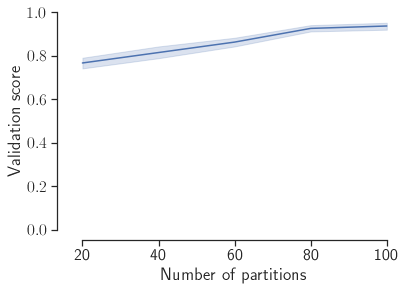

In [42]:
validation_data["score"] = (validation_data["n_validated"]/validation_data["n_validation"]).astype(float)
validation_data["n_partitions"] = validation_data["n_partitions"].astype(int)
sns.set(style="ticks",font_scale=1.5)
ax = sns.lineplot(x="n_partitions", y="score", markers=True, data=validation_data)
ax.set(ylabel="Validation score",xlabel="Number of partitions",ylim=(0,1))
##plt.legend(loc=4)
sns.despine(offset=10, trim=True);

plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda x, _: int(x)))
plt.savefig('results/ValidationScore.pdf')

# Compare partitions

In [43]:

%load_ext autoreload
%autoreload 2

from sklearn.manifold import MDS
from sklearn.manifold import LocallyLinearEmbedding
from scipy.interpolate import griddata
import umap

### Find partitions (not necessary if already done above)

In [44]:
generatePartitions = False
if generatePartitions:
    partitions = pd.DataFrame() 
    niter=50
    for i in range(niter):
        print("Iteration " + str(i+1))
        codelength = findCommunities(G,i)
        communities = [v for k,v in nx.get_node_attributes(G, 'community').items()]
        communities.insert(0,codelength)
        partitions = pd.concat([partitions, pd.DataFrame(communities,columns = [str(i)])], axis=1)

### Identify partition clusters

In [45]:
distance_threshold = 0.2
partitions.sort_values(by=0, axis=1,inplace=True)
codelengths = partitions.loc[0,:].to_numpy()
partitions.drop(0, axis=0,inplace=False).to_csv(r'results/partitions.csv',index=False,header=False,sep=' ')
!partition-validation/partition-validation -s 123 -t $distance_threshold results/partitions.csv results/partitions_clustering.txt    

Version: March 5, 2020.
Command: partition-validation/partition-validation -s 123 -t 0.2 results/partitions.csv results/partitions_clustering.txt
Setup:
-->Using seed: 123
-->Will cluster partitions such that no partition is farther away from its center than: 0.2
-->Will read partitions from file: results/partitions.csv
-->Will write clusters to file: results/partitions_clustering.txt
-->Will use number of threads: 1
Reading partitions file with 100 partitions...of 7769 nodes...done!
Clustering 100 partitions:
-->Writing 12 clusters...done!


### Read results and identify cluster sizes and cluster centers

#### Read partition clusters

In [46]:
partition_clusters_df = pd.read_csv('results/partitions_clustering.txt',delimiter=' ',comment='#')
partition_clusters_df.head()

,ClusterId,PartitionId
0,1,1
1,1,2
2,1,3
3,1,6
4,1,8


#### Cluster sizes

In [47]:
clusterSizes = partition_clusters_df['ClusterId'].value_counts(sort=False)
solution_landscape_df = clusterSizes.to_frame().rename(columns={'ClusterId':'clustersize'})

#### Cluster centers and code lengths

In [48]:
Nclusters = partition_clusters_df['ClusterId'].max()
clusterCenters = np.empty(Nclusters)
for clusterId in range(1,Nclusters+1):
    clusterCenters[clusterId-1] = partition_clusters_df['PartitionId'][(partition_clusters_df['ClusterId'] == clusterId).idxmax()]
clusterCenters = clusterCenters.astype(int)
clusterCenterCodelengths = codelengths[clusterCenters-1]
solution_landscape_df['partitionid'] = clusterCenters.tolist()
solution_landscape_df['codelength'] = clusterCenterCodelengths.tolist()

#### Read partition distances

In [49]:
distances_df = pd.read_csv('results/partitions_clustering_distances.txt',delimiter=' ',comment='#')

#### Create partition distance matrix

Text(0.5, 1.0, 'Partition distance matrix')

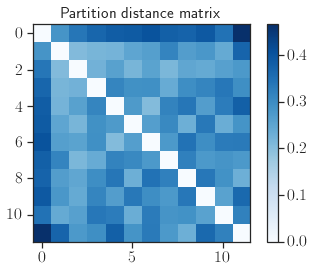

In [50]:
row = distances_df.to_numpy()[:,0].astype(int)-1
col = distances_df.to_numpy()[:,1].astype(int)-1
distances = distances_df.to_numpy()[:,2]
distance_matrix = np.zeros((Nclusters, Nclusters), dtype=distances.dtype)
distance_matrix[row,col] = distances
distance_matrix[col,row] = distances # Add transpose
plt.imshow(distance_matrix, zorder=2, cmap='Blues', interpolation='nearest')
plt.colorbar();
plt.title('Partition distance matrix', fontsize=16)

#### Identify coordinates in 2D with Uniform Manifold Approximation and Projection (UMAP)

In [51]:
U = umap.UMAP(metric='precomputed',n_neighbors=Nclusters-1,min_dist=distance_threshold)
out = U.fit_transform(distance_matrix)
solution_landscape_df['xcoord'] = out[:, 0]
solution_landscape_df['ycoord'] = out[:, 1]
solution_landscape_df.head()

,clustersize,partitionid,codelength,xcoord,ycoord
1,43,1,10.021130,1.056401,13.283581
2,29,4,10.025956,1.210851,12.453712
3,13,23,10.040303,2.140852,12.922773
4,1,32,10.044802,1.576416,11.744918
5,2,56,10.060736,3.473281,11.849105


#### Visualize solution landscape with contour plot

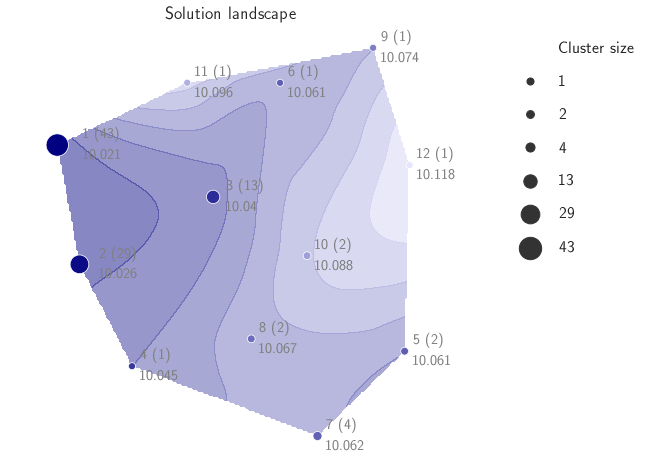

In [52]:
x = solution_landscape_df['xcoord'].values
y = solution_landscape_df['ycoord'].values
codelength = solution_landscape_df['codelength'].values

def plot_contour(x,y,codelength,resolution = 200,contour_method='cubic'):
    resolution = str(resolution)+'j'
    X,Y = np.mgrid[min(x):max(x):complex(resolution),   min(y):max(y):complex(resolution)]
    points = [[a,b] for a,b in zip(x,y)]
    Z = griddata(points, codelength, (X, Y), method=contour_method)
    return X,Y,Z

X,Y,Z = plot_contour(x,y,codelength,resolution = 200,contour_method='cubic')

palette = sns.light_palette("navy", reverse=True, as_cmap=True)
sns.set(style="whitegrid",font_scale=1.5)
f, ax = plt.subplots(figsize=(8, 8))
sns.despine(f, left=True, bottom=True)
ax.contourf(X,Y,Z,cmap=palette,alpha=0.5)
p1 = sns.scatterplot(x="xcoord", y="ycoord", hue="codelength",size="clustersize",
            sizes=(50, 500), alpha=1,palette=palette,legend="full",
            data=solution_landscape_df)
plt.axis('equal');
plt.title('Solution landscape')
plt.xlabel('')
#plt.xlabel('Embedded partition distance')
plt.ylabel('')
plt.xticks([])
plt.yticks([])
handles,labels = ax.get_legend_handles_labels()
labels[Nclusters+1] = 'Cluster size'
plt.legend(handles[Nclusters+1:],labels[Nclusters+1:],bbox_to_anchor=(1.1, 1), loc='upper left', frameon=False,ncol=1, labelspacing=1.1)

for clusterId in range(1,len(out)+1):
     p1.text(solution_landscape_df['xcoord'].iloc[clusterId-1]+0.003*solution_landscape_df['clustersize'].iloc[clusterId-1]+0.05, solution_landscape_df['ycoord'].iloc[clusterId-1]-0.1, 
     np.around(solution_landscape_df['codelength'].iloc[clusterId-1],decimals=3), horizontalalignment='left', 
     size='small', color='gray', weight='semibold')
     p1.text(solution_landscape_df['xcoord'].iloc[clusterId-1]+0.003*solution_landscape_df['clustersize'].iloc[clusterId-1]+0.05, solution_landscape_df['ycoord'].iloc[clusterId-1]+0.05, 
     str(clusterId) + str(" (") + str(solution_landscape_df['clustersize'].iloc[clusterId-1]) + str(")"), horizontalalignment='left', 
     size='small', color='gray', weight='semibold')

plt.savefig('results/SolutionLandscape.pdf')    


#### Print selected cluster centers and visualize their differences
Can be analyzed and compared in https://www.mapequation.org/alluvial/

In [53]:
clusterIds = [1,2,12]
for clusterId in clusterIds:
    seed = int(partitions.columns[solution_landscape_df['partitionid'].iloc[clusterId-1]-1])
    printCommunities(G,seed,outfile="results/cluster_center_" + str(clusterId) + ".tree")

Building Infomap network from a NetworkX graph...
Find communities with Infomap...
Found 6 top modules with codelength: 10.021130443369788
Writing results to results/cluster_center_1.tree
Building Infomap network from a NetworkX graph...
Find communities with Infomap...
Found 203 top modules with codelength: 10.025956388832142
Writing results to results/cluster_center_2.tree
Building Infomap network from a NetworkX graph...
Find communities with Infomap...
Found 209 top modules with codelength: 10.118184287208186
Writing results to results/cluster_center_12.tree


Close-by cluster centers visually look more similar than distant cluster centers

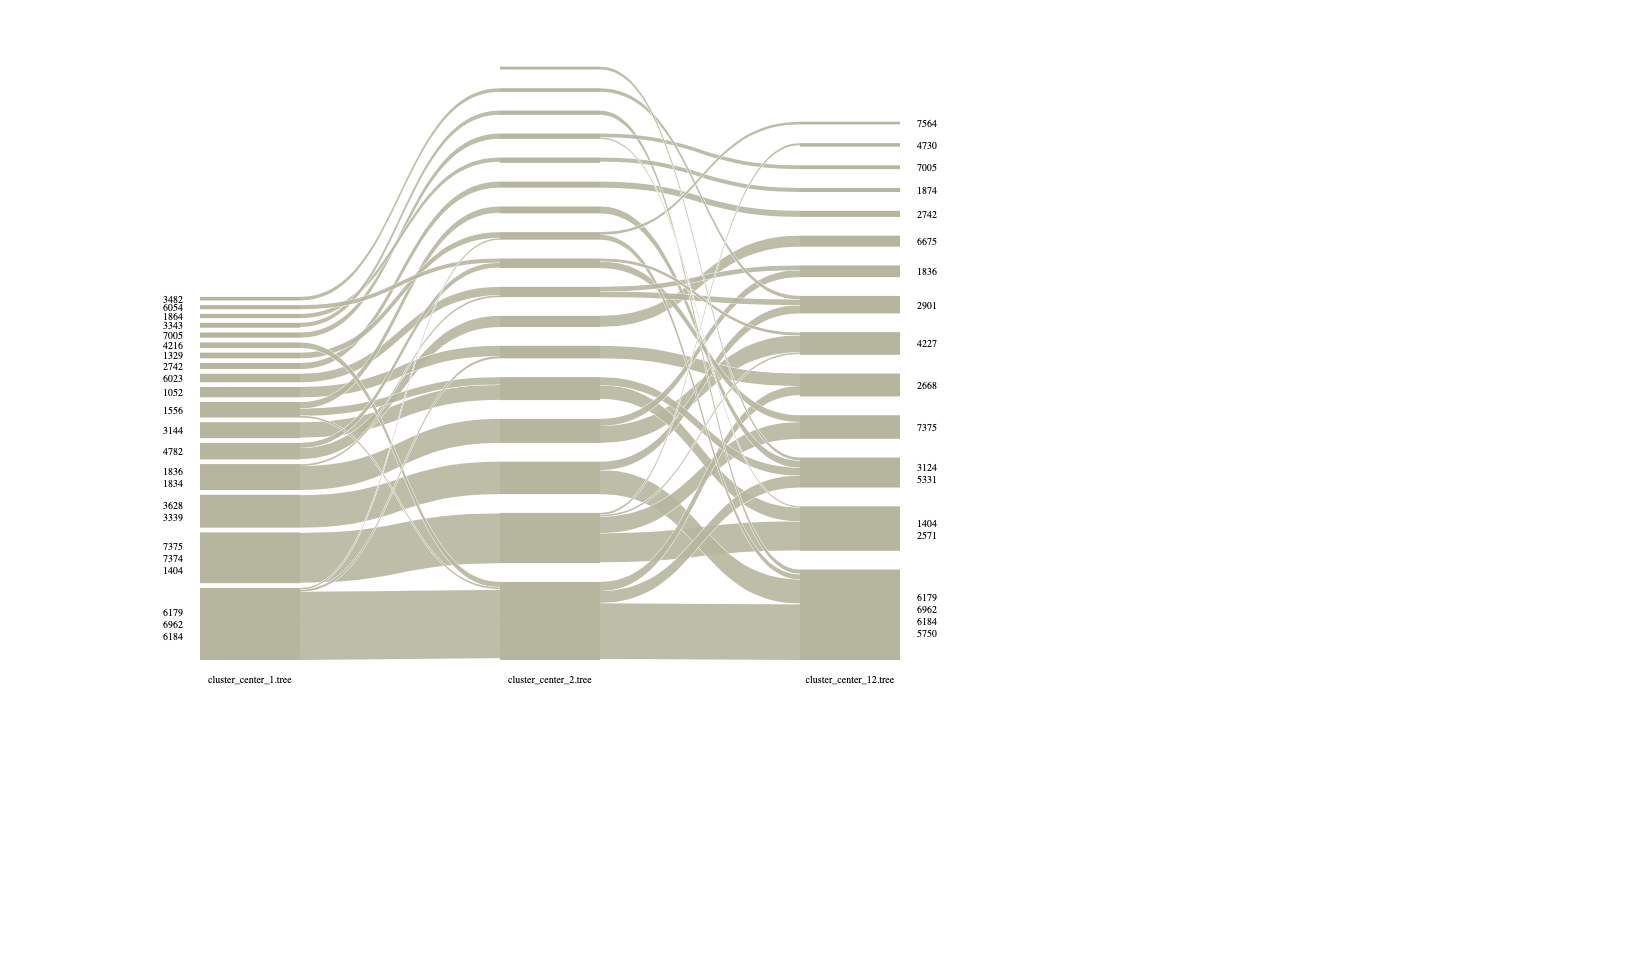

In [54]:
from IPython.display import Image
Image(filename='results/cluster_center_1.tree,cluster_center_2.tree,cluster_center_12.tree.png')